## Importing libraries

This MLP network is created from scratch using only the numpy library. It focuses on introductory algorithms and techniques, making numpy the sole necessary library. This minimalist approach highlights the fundamental concepts of neural networks while relying on numpy's powerful numerical computations for essential operations.


In [3]:
import sys
sys.path.insert(0, '../helper')
import mnist_loader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn import metrics
from sklearn.linear_model import Perceptron

## Activation Functions Class

In [4]:
class Activation:
  """
    - Activation functions.
    - And their derivatives
  """

  @classmethod
  def sigmoid(cls, vec):
    """
      Sigmoid activation function.
    """
    return 1.0 / (1.0 + np.exp(-vec))

  @classmethod
  def sigmoid_drv(cls, vec):
    """
      Sigmoid function derivative.
    """
    return cls.sigmoid(vec) * (1 - cls.sigmoid(vec))

  @classmethod
  def step(cls, vec):
    """
      Binary Step activation function.
    """
    return np.where(vec > 0, 1, 0)

  @classmethod
  def relu(cls, vec):
    """
      Rectified Linear Unit
    """
    return np.maximum(0, vec)

  @classmethod
  def relu_drv(cls, vec):
    """
      Rectified Linear Unit Derivative
    """
    return np.where(vec > 0, 1, 0)

  @classmethod
  def tanh(cls, vec):
    """
      Hiperbolic Tangent
    """
    return np.tanh(vec)

  @classmethod
  def tanh_drv(cls, vec):
    """
      Hiperbolic Tangent Derivative
    """
    return 1 - np.tanh(vec)**2

## Cost Function Class

In [5]:
class Cost:
  """
    - Cost functions.
  """

  @classmethod
  def cost_derivative(cls, output_activations, y):
    """
      - Return the vector of partial derivatives partial C(x).
      - Partial a for the output activations.
    """
    return (output_activations-y)

  @classmethod
  def mean_squared_error(cls, output, target):
    """
    Calculates the mean squared error between the output and the target.

    :param output: The output of the network.
    :param target: The desired output.
    :return: The mean squared error.
    """
    diff = output - target
    differences_squared = 0.5 *(diff ** 2)
    mean_diff = differences_squared.mean()

    return mean_diff

## Network Object

In [6]:
class Network:
  """
    - A Feed Foward Neural Network.
    - Uses Stochastic Gradient Descent learning algorithm.
    - Gradients are being caculated using back propagation.
    - Misses some optimizations and omits some desirable features.
  """
  def __init__(self, sizes, activation_function = Activation.sigmoid, actv_drv = Activation.sigmoid_drv):
    self.num_layers = len(sizes)
    self.sizes = sizes
    self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
    self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]
    self.activation_function = activation_function
    self.actv_drv = actv_drv

  def feed_foward(self, a):
    """
      Calculates the final result of a input going through the NN.
    """
    for b, w in zip(self.biases, self.weights):
      a = self.activation_function(np.dot(w, a) + b)
    return a

  def update_mini_batch(self,  mini_batch, eta):
    """
      - Updates the network's weights and biases by applying gradient descent using backpropagation to a single mini batch.
      - The "mini_batch" is a list of tuples "(x, y)".
      - "eta is the learning rate.
    """

    nabla_b = [np.zeros(b.shape) for b in self.biases]
    nabla_w = [np.zeros(w.shape) for w in self.weights]

    # Nabla lists are lists of numpy arrays, in the same way as self.weights and self.biases
    # They store, by adding, all the changes in the weights calculated by the back propagation algorithm
    for x, y in mini_batch:
      delta_nabla_b, delta_nabla_w = self.back_propagation(x, y)

      nabla_b = [nb + dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
      nabla_w = [nw + dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]

    # Recalculate weights for a mini-batch run
    self.weights = [w - (eta/len(mini_batch)) * nw for w, nw in zip(self.weights, nabla_w)]
    self.biases = [b - (eta/len(mini_batch)) * nb for b, nb in zip(self.biases, nabla_b)]

  def SGD(self, training_data, epochs, mini_batch_size, eta, test_data=None):
    """
      - Utilizes mini-batch stochastic gradient descent for training the neural network.
      - The "training_data" consists of tuples "(x, y)" representing input and desired output.
      - Other parameters are self-explanatory.
      - If "test_data" is provided, the network evaluates against it after each epoch, allowing for progress tracking but at a slower pace.
    """

    if test_data:
      test_data = list(test_data)
      n_test = len(test_data)

    training_data = list(training_data)
    n = len(training_data)

    for j in range(epochs):
      random.shuffle(training_data)
      mini_batches = [training_data[k:k+mini_batch_size] for k in range(0, n, mini_batch_size)]

      for mini_batch in mini_batches:
        self.update_mini_batch(mini_batch, eta)

      if test_data :
        print(f"Epoch {j}: {self.evaluate(test_data, n_test)}")
        print(f"Loss: {self.calculate_loss(test_data, n_test)}")

      else:
        print(f"Epoch {j}: complete")


  def back_propagation(self, x, y):
    """
      - Returns a tuple "(nabla_b, nabla_w)" representing the gradient for the chosen Cost Function C(x).
      - "nabla_b" & "nabla_w" are layer-by-layer lists of numpy arrays.
      - Similar to "self.biases" and "self.weights".
      - How much is the adjustment.
    """

    nabla_b = [np.zeros(b.shape) for b in self.biases]
    nabla_w = [np.zeros(w.shape) for w in self.weights]

    # Feed-foward phase

    activation = x
    activations = [x] # Stores activations layer by layer
    zs = [] # Stores all the z vectores, layer-by-layer

    for b, w in zip(self.biases, self.weights):
      z = np.dot(w, activation) + b
      zs.append(z)
      activation = self.activation_function(z)
      activations.append(activation)

    # Backward pass -> delta rule
    delta = Cost.cost_derivative(activations[-1], y) * self.actv_drv(zs[-1])

    nabla_b[-1] = delta
    nabla_w[-1] = np.dot(delta, activations[-2].transpose())

    # In the following loop we want to iterate from the last to the first layer, excluding the output and the input layers
    # We are taking advantage that python can use negative indices

    for l in range(2, self.num_layers):
      z = zs[-l]
      sig_dv = self.actv_drv(z)
      delta = np.dot(self.weights[-l+1].transpose(), delta) * sig_dv
      nabla_b[-l] = delta
      nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())

    return (nabla_b, nabla_w)


  def evaluate(self, test_data, len_test_data):
    """
      - Evaluates the number of correct predictions of the NN.
      - The output is chosen by the "winner takes all" rule, where the highest number on the output vector is the prediction
    """
    test_results = [(np.argmax(self.feed_foward(x)), y) for (x, y) in test_data]

    return sum (int(x == y) for (x, y) in test_results) / len_test_data

  def calculate_loss(self, test_data, len_test_data, cost_function=Cost.mean_squared_error):
          """
          Calculates the loss for a given dataset using the specified cost function.

          :param data: A list of tuples "(x, y)" representing input and desired output.
          :param cost_function: The cost function to calculate the loss (default: mean squared error).
          :return: The calculated loss.
          """
          test_data = list(test_data)
          loss = 0.0
          for x, y in test_data:
              output = self.feed_foward(x)
              prediction = np.argmax(output)
              loss += cost_function(prediction, y)
          return loss / len_test_data


  def debug(self):
    """
      - Write any code for debbuging.
    """

## Tuning

Now, we're going to explore the hyperparameters of this MLP, in order to find the most adequate configuration for it.

### Activation Function

#### Sigmoid Function

The sigmoid function yielded the best results so far. When we used the same parameter values for all the functions, the sigmoid function achieved an accuracy of over 90%, while the other functions only reached around 10%-20% accuracy. Therefore, it's clear that the sigmoid function outperformed the others in terms of accuracy. The behaviour of the net while using the sigmoid function is much more desirable, the tendency of it its to keep improving its perfomance.

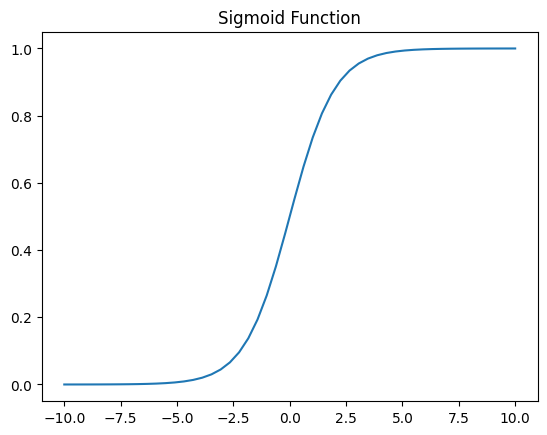

In [7]:
x = np.linspace(-10, 10)
y = Activation.sigmoid(x)

plt.plot(x, y)
plt.title("Sigmoid Function")
plt.show()

In [9]:
net = Network([784, 30, 10])
training_data, validation_data, test_data = mnist_loader.load_data_wrapper()

#epochs, mini_batch_size, eta,
net.SGD(training_data, 30, 10, 4.0, test_data=test_data)

Epoch 0: 0.9091
Loss: 0.82285
Epoch 1: 0.9232
Loss: 0.66285
Epoch 2: 0.9355
Loss: 0.5516
Epoch 3: 0.9364
Loss: 0.57925
Epoch 4: 0.9409
Loss: 0.4651
Epoch 5: 0.9439
Loss: 0.4902
Epoch 6: 0.9439
Loss: 0.4832
Epoch 7: 0.9461
Loss: 0.48275
Epoch 8: 0.9459
Loss: 0.4599
Epoch 9: 0.9463
Loss: 0.43925
Epoch 10: 0.9448
Loss: 0.48435
Epoch 11: 0.9476
Loss: 0.46615
Epoch 12: 0.9488
Loss: 0.4401
Epoch 13: 0.9509
Loss: 0.4043
Epoch 14: 0.9432
Loss: 0.44965
Epoch 15: 0.9487
Loss: 0.4364
Epoch 16: 0.9507
Loss: 0.41825
Epoch 17: 0.9523
Loss: 0.3938
Epoch 18: 0.9523
Loss: 0.44045
Epoch 19: 0.9512
Loss: 0.43325
Epoch 20: 0.9502
Loss: 0.4443
Epoch 21: 0.9508
Loss: 0.43305
Epoch 22: 0.9508
Loss: 0.4255
Epoch 23: 0.9506
Loss: 0.4328
Epoch 24: 0.9513
Loss: 0.428
Epoch 25: 0.9501
Loss: 0.4193
Epoch 26: 0.9522
Loss: 0.42125
Epoch 27: 0.953
Loss: 0.39445
Epoch 28: 0.9536
Loss: 0.381
Epoch 29: 0.9528
Loss: 0.40105


#### Tanh Function


The hyperbolic tangent (tanh) function didn't give us good results. We used the same parameters as before when we were using the sigmoid function, but the tanh function didn't work well in this case. Initially, the accuracy improved in the first 5-7 epochs, but after that, the performance of the network either stayed the same or got worse. Overall, the tanh function didn't perform well.

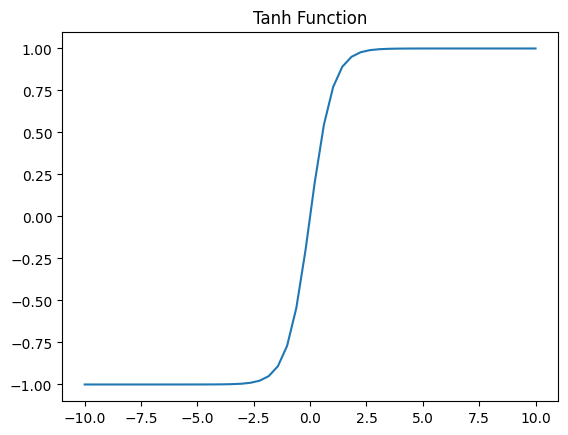

In [10]:
x = np.linspace(-10, 10)
y = Activation.tanh(x)

plt.plot(x, y)
plt.title("Tanh Function")
plt.show()

In [11]:
net = Network([784, 30, 10], Activation.tanh, Activation.tanh_drv)
training_data, validation_data, test_data = mnist_loader.load_data_wrapper()

#epochs, mini_batch_size, eta,
net.SGD(training_data, 30, 10, 4.0, test_data=test_data)

Epoch 0: 0.1684
Loss: 12.9795
Epoch 1: 0.183
Loss: 13.8845
Epoch 2: 0.1856
Loss: 13.8783
Epoch 3: 0.1445
Loss: 14.0192
Epoch 4: 0.1954
Loss: 13.39955
Epoch 5: 0.0984
Loss: 14.0486
Epoch 6: 0.0984
Loss: 14.0427
Epoch 7: 0.0985
Loss: 14.03835
Epoch 8: 0.2011
Loss: 13.5216
Epoch 9: 0.2006
Loss: 13.48925
Epoch 10: 0.1863
Loss: 13.97565
Epoch 11: 0.1986
Loss: 13.90285
Epoch 12: 0.1871
Loss: 13.96945
Epoch 13: 0.2071
Loss: 12.79395
Epoch 14: 0.1964
Loss: 10.5728
Epoch 15: 0.134
Loss: 14.0326
Epoch 16: 0.1686
Loss: 13.84375
Epoch 17: 0.1377
Loss: 14.02575
Epoch 18: 0.1271
Loss: 14.0377
Epoch 19: 0.1253
Loss: 14.04145
Epoch 20: 0.1173
Loss: 14.04175
Epoch 21: 0.1159
Loss: 14.046
Epoch 22: 0.1161
Loss: 14.0457
Epoch 23: 0.1188
Loss: 14.0455
Epoch 24: 0.1336
Loss: 10.20975
Epoch 25: 0.2037
Loss: 11.5062
Epoch 26: 0.1887
Loss: 13.6111
Epoch 27: 0.2037
Loss: 11.4996
Epoch 28: 0.2068
Loss: 12.4572
Epoch 29: 0.1981
Loss: 13.3673


### ETA - learning rate

In this section we've decided to follow a common approach, keep increasing the learning rate untill the model's accuracy starts to go down, so that we can have the most apropriate learning rate for the problem.

For the matter of the comparison, we've reduced the number of epochs, so that the training process could become quicker, but it still took a long time to bring the results up.

Was you'll see in the graph above, the most adequate learing rate was aroud 6, as we increase the ETA the accuracy decreases very abruptaly.

#### From 0.1-0.9

Epoch 0: complete
Epoch 1: complete
Epoch 2: complete
Epoch 3: complete
Epoch 4: complete
Epoch 5: complete
Epoch 6: complete
Epoch 7: complete
Epoch 8: complete
Epoch 9: complete
Epoch 10: complete
Epoch 11: complete
Epoch 12: complete
Epoch 13: complete
Epoch 14: complete
Epoch 15: complete
Epoch 16: complete
Epoch 17: complete
Epoch 18: complete
Epoch 19: complete
Epoch 0: complete
Epoch 1: complete
Epoch 2: complete
Epoch 3: complete
Epoch 4: complete
Epoch 5: complete
Epoch 6: complete
Epoch 7: complete
Epoch 8: complete
Epoch 9: complete
Epoch 10: complete
Epoch 11: complete
Epoch 12: complete
Epoch 13: complete
Epoch 14: complete
Epoch 15: complete
Epoch 16: complete
Epoch 17: complete
Epoch 18: complete
Epoch 19: complete
Epoch 0: complete
Epoch 1: complete
Epoch 2: complete
Epoch 3: complete
Epoch 4: complete
Epoch 5: complete
Epoch 6: complete
Epoch 7: complete
Epoch 8: complete
Epoch 9: complete
Epoch 10: complete
Epoch 11: complete
Epoch 12: complete
Epoch 13: complete
Epoc

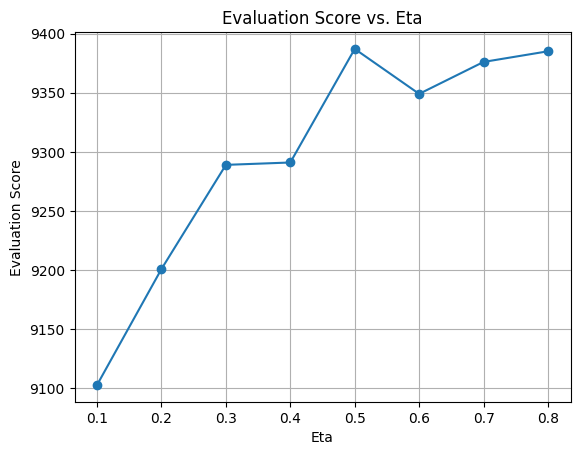

In [ ]:
res = []
etas = [eta / 10 for eta in range(1, 10)]  # Learning rates
losses = []

for index, eta in enumerate(etas):
  print(f"\nTraining {index+1}, using eta: {eta}\n")
  net = Network([784, 30, 10])
  training_data, validation_data, test_data = mnist_loader.load_data_wrapper()

  test_data = list(test_data)
  n_test = len(test_data)

  net.SGD(training_data, 20, 10, eta)
  res.append(net.evaluate(test_data, n_test))
  losses.append(net.calculate_loss(test_data, n_test))

plt.plot(etas, res, marker='o')
plt.xlabel('Eta')
plt.ylabel('Evaluation Score')
plt.title('Evaluation Score vs. Eta')
plt.grid(True)
plt.show()

#### From 1-9

Training 0, using eta: 1

Epoch 0: complete
Epoch 1: complete
Epoch 2: complete
Epoch 3: complete
Epoch 4: complete
Epoch 5: complete
Epoch 6: complete
Epoch 7: complete
Epoch 8: complete
Epoch 9: complete
Epoch 10: complete
Epoch 11: complete
Epoch 12: complete
Epoch 13: complete
Epoch 14: complete
Epoch 15: complete
Epoch 16: complete
Epoch 17: complete
Epoch 18: complete
Epoch 19: complete
Training 1, using eta: 2

Epoch 0: complete
Epoch 1: complete
Epoch 2: complete
Epoch 3: complete
Epoch 4: complete
Epoch 5: complete
Epoch 6: complete
Epoch 7: complete
Epoch 8: complete
Epoch 9: complete
Epoch 10: complete
Epoch 11: complete
Epoch 12: complete
Epoch 13: complete
Epoch 14: complete
Epoch 15: complete
Epoch 16: complete
Epoch 17: complete
Epoch 18: complete
Epoch 19: complete
Training 2, using eta: 3

Epoch 0: complete
Epoch 1: complete
Epoch 2: complete
Epoch 3: complete
Epoch 4: complete
Epoch 5: complete
Epoch 6: complete
Epoch 7: complete
Epoch 8: complete
Epoch 9: complete
Ep

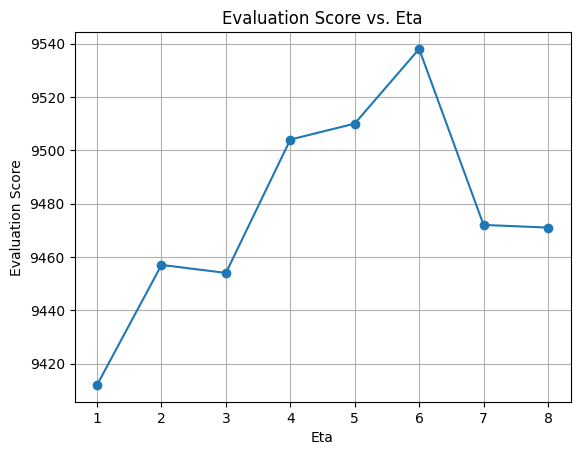

In [ ]:
res = []
etas = [eta for eta in range(1, 10)]  # Learning rates
losses = []
for index, eta in enumerate(etas):
  print(f"\nTraining {index+1}, using eta: {eta}\n")
  net = Network([784, 30, 10])
  training_data, validation_data, test_data = mnist_loader.load_data_wrapper()

  test_data = list(test_data)
  n_test = len(test_data)

  net.SGD(training_data, 20, 10, eta)
  res.append(net.evaluate(test_data, n_test))
  losses.append(net.calculate_loss(test_data, n_test))

plt.plot(etas, res, marker='o')
plt.xlabel('Eta')
plt.ylabel('Evaluation Score')
plt.title('Evaluation Score vs. Eta')
plt.grid(True)
plt.show()

#### From 6-6.9

In this test we can see a very curious case, in which the loss goes very high up when the learning rate is set to 6.7


Training 1, using eta: 6.0

Epoch 0: complete
Epoch 1: complete
Epoch 2: complete
Epoch 3: complete
Epoch 4: complete
Epoch 5: complete
Epoch 6: complete
Epoch 7: complete
Epoch 8: complete
Epoch 9: complete
Epoch 10: complete
Epoch 11: complete
Epoch 12: complete
Epoch 13: complete
Epoch 14: complete
Epoch 15: complete
Epoch 16: complete
Epoch 17: complete
Epoch 18: complete
Epoch 19: complete

Training 2, using eta: 6.1

Epoch 0: complete
Epoch 1: complete
Epoch 2: complete
Epoch 3: complete
Epoch 4: complete
Epoch 5: complete
Epoch 6: complete
Epoch 7: complete
Epoch 8: complete
Epoch 9: complete
Epoch 10: complete
Epoch 11: complete
Epoch 12: complete
Epoch 13: complete
Epoch 14: complete
Epoch 15: complete
Epoch 16: complete
Epoch 17: complete
Epoch 18: complete
Epoch 19: complete

Training 3, using eta: 6.2

Epoch 0: complete
Epoch 1: complete
Epoch 2: complete
Epoch 3: complete
Epoch 4: complete
Epoch 5: complete
Epoch 6: complete
Epoch 7: complete
Epoch 8: complete
Epoch 9: co

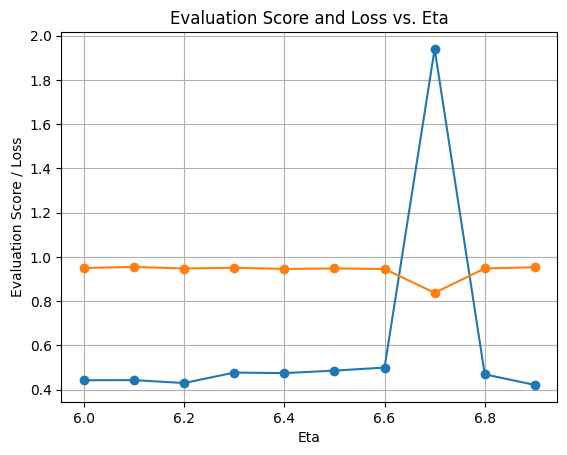

In [ ]:
res = []
etas = [eta/10 for eta in range(60, 70)]  # Learning rates
losses = []

for index, eta in enumerate(etas):
  print(f"\nTraining {index+1}, using eta: {eta}\n")
  net = Network([784, 30, 10])
  training_data, validation_data, test_data = mnist_loader.load_data_wrapper()

  test_data = list(test_data)
  n_test = len(test_data)

  net.SGD(training_data, 20, 10, eta)
  res.append(net.evaluate(test_data, n_test))
  losses.append(net.calculate_loss(test_data, n_test))

plt.plot(etas, losses, marker='o', label='Loss')  # Plotting the loss line graph
plt.plot(etas, res, marker='o', label='Evaluation Score')  # Plotting the evaluation score line graph
plt.xlabel('Eta')
plt.ylabel('Evaluation Score / Loss')
plt.title('Evaluation Score and Loss vs. Eta')
plt.grid(True)

### Mini batch size



The mini-batch size behaved in a more consistent manner than the ETA during its development. It showed small and gradual increases and decreases, indicating a stable and predictable pattern throughout the training process.


Training 1, using eta: 2

Epoch 0: complete
Epoch 1: complete
Epoch 2: complete
Epoch 3: complete
Epoch 4: complete
Epoch 5: complete
Epoch 6: complete
Epoch 7: complete
Epoch 8: complete
Epoch 9: complete
Epoch 10: complete
Epoch 11: complete
Epoch 12: complete
Epoch 13: complete
Epoch 14: complete
Epoch 15: complete
Epoch 16: complete
Epoch 17: complete
Epoch 18: complete
Epoch 19: complete

Training 2, using eta: 4

Epoch 0: complete
Epoch 1: complete
Epoch 2: complete
Epoch 3: complete
Epoch 4: complete
Epoch 5: complete
Epoch 6: complete
Epoch 7: complete
Epoch 8: complete
Epoch 9: complete
Epoch 10: complete
Epoch 11: complete
Epoch 12: complete
Epoch 13: complete
Epoch 14: complete
Epoch 15: complete
Epoch 16: complete
Epoch 17: complete
Epoch 18: complete
Epoch 19: complete

Training 3, using eta: 6

Epoch 0: complete
Epoch 1: complete
Epoch 2: complete
Epoch 3: complete
Epoch 4: complete
Epoch 5: complete
Epoch 6: complete
Epoch 7: complete
Epoch 8: complete
Epoch 9: complete

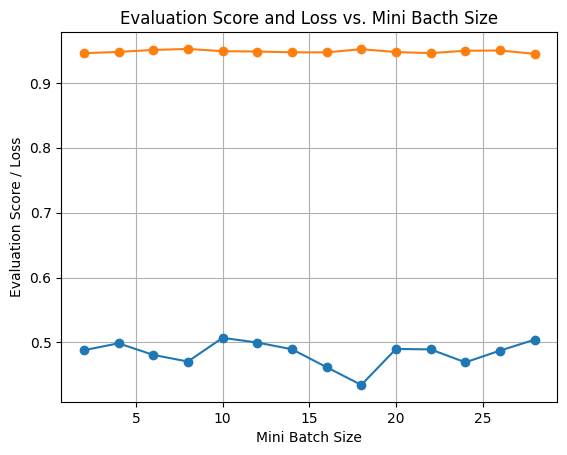

In [ ]:
res = []
mini_batch_sizes = [sz for sz in range(2, 30, 2)]  # Mini batch size
losses = []

for index, sz in enumerate(mini_batch_sizes):
  print(f"\nTraining {index+1}, using size: {sz}\n")
  net = Network([784, 30, 10])
  training_data, validation_data, test_data = mnist_loader.load_data_wrapper()

  test_data = list(test_data)
  n_test = len(test_data)

  net.SGD(training_data, 20, 10, 6)
  res.append(net.evaluate(test_data, n_test))
  losses.append(net.calculate_loss(test_data, n_test))

plt.plot(mini_batch_sizes, losses, marker='o', label='Loss')  # Plotting the loss line graph
plt.plot(mini_batch_sizes, res, marker='o', label='Evaluation Score')  # Plotting the evaluation score line graph
plt.xlabel('Mini Batch Size')
plt.ylabel('Evaluation Score / Loss')
plt.title('Evaluation Score and Loss vs. Mini Bacth Size')
plt.grid(True)

### Number of Epochs

Although the accuracy of the model remained consistent throughout all epochs, the loss function showed slight variations. Certain epochs were more effective than others in minimizing the loss function. Based on the test conducted, the most accurate result was achieved after 27 epochs.


Training 1, using 1 epoch(s)

Epoch 0: complete

Training 2, using 2 epoch(s)

Epoch 0: complete
Epoch 1: complete

Training 3, using 3 epoch(s)

Epoch 0: complete
Epoch 1: complete
Epoch 2: complete

Training 4, using 4 epoch(s)

Epoch 0: complete
Epoch 1: complete
Epoch 2: complete
Epoch 3: complete

Training 5, using 5 epoch(s)

Epoch 0: complete
Epoch 1: complete
Epoch 2: complete
Epoch 3: complete
Epoch 4: complete

Training 6, using 6 epoch(s)

Epoch 0: complete
Epoch 1: complete
Epoch 2: complete
Epoch 3: complete
Epoch 4: complete
Epoch 5: complete

Training 7, using 7 epoch(s)

Epoch 0: complete
Epoch 1: complete
Epoch 2: complete
Epoch 3: complete
Epoch 4: complete
Epoch 5: complete
Epoch 6: complete

Training 8, using 8 epoch(s)

Epoch 0: complete
Epoch 1: complete
Epoch 2: complete
Epoch 3: complete
Epoch 4: complete
Epoch 5: complete
Epoch 6: complete
Epoch 7: complete

Training 9, using 9 epoch(s)

Epoch 0: complete
Epoch 1: complete
Epoch 2: complete
Epoch 3: complete
E

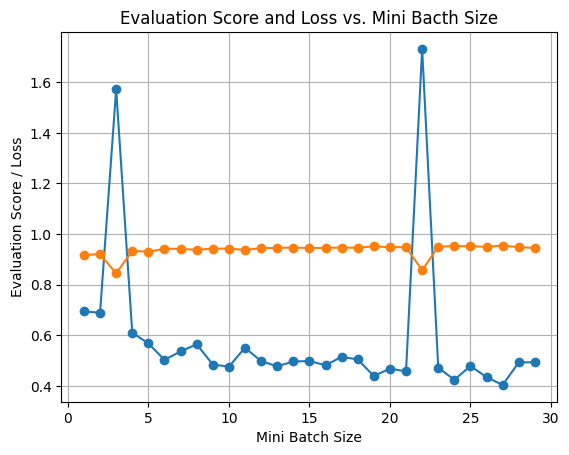

In [12]:
res = []
epochs = [epoch for epoch in range(1, 30)]  # Amount of Epochs
losses = []

for index, epoch in enumerate(epochs):
  print(f"\nTraining {index+1}, using {epoch} epoch(s)\n")
  net = Network([784, 30, 10])
  training_data, validation_data, test_data = mnist_loader.load_data_wrapper()

  test_data = list(test_data)
  n_test = len(test_data)

  net.SGD(training_data, epoch, 10, 6)
  res.append(net.evaluate(test_data, n_test))
  losses.append(net.calculate_loss(test_data, n_test))

plt.plot(epochs, losses, marker='o', label='Loss')  # Plotting the loss line graph
plt.plot(epochs, res, marker='o', label='Evaluation Score')  # Plotting the evaluation score line graph
plt.xlabel('Number of Epochs')
plt.ylabel('Evaluation Score / Loss')
plt.title('Evaluation Score and Loss vs. Number of Epochs')
plt.grid(True)

### Regularization / Droup-out

### The network architecture

### Machine Learning Algorithm